In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

numpy = lambda x : x.detach().cpu().numpy()

# Automatic Differentiation
aka. differentiable Programming

**references**
- https://pytorch.org/docs/stable/autograd.html
- Baydin, Pearlmutter, Radul, Siskind 2018 Automatic Differentiation in Machine Learning: a survey

In [2]:
# grad works great on vector input scalar output functions

# input
input_dim = 2

x = torch.randint(0,10,(input_dim, 1), dtype=dtype, requires_grad=True)
print(x)

# output
y = (x ** 2).sum()
print(y)

tensor([[9.],
        [5.]], requires_grad=True)
tensor(106., grad_fn=<SumBackward0>)


In [3]:
# as expected
torch.autograd.grad(y, x), 2 * x

((tensor([[18.],
          [10.]]),), tensor([[18.],
         [10.]], grad_fn=<MulBackward0>))

## Explicit Jacobian

For vector vector functions, we can explicitelly get the jacobian matrix dy/dx  
by passing impulses in the output space to backward 

In [4]:
output_dim = 3

M = torch.randint(0,10,(output_dim,input_dim), dtype=dtype)
y = torch.mm(M,x)

M

tensor([[2., 8.],
        [3., 5.],
        [8., 7.]])

In [5]:
J = torch.zeros((output_dim, input_dim))

U = torch.eye(output_dim)

torch.autograd.backward([y], [U[:,0][:,None]], retain_graph=True)
J[0,:] = x.grad.data.squeeze()
x.grad.data.zero_()
torch.autograd.backward([y], [U[:,1][:,None]], retain_graph=True)
J[1,:] = x.grad.data.squeeze()
x.grad.data.zero_()
torch.autograd.backward([y], [U[:,2][:,None]], retain_graph=True)
J[2,:] = x.grad.data.squeeze()
x.grad.data.zero_();

In [6]:
# The Jacobian is the best linear approximation to the map f
# https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant
# So in the linear case we get J = M
J

tensor([[2., 8.],
        [3., 5.],
        [8., 7.]])

In [7]:
help(po.synth.autodiff.jacobian)

Help on function jacobian in module plenoptic.synthesize.autodiff:

jacobian(y, x)
    Build the full Jacobian matrix (does not scale).
    
    Parameters
    ----------
    y: torch tensor with gradient function
        output
    x: torch tensor with gradient function
        input
    
    Returns
    -------
    J: torch tensor
        Jacobian matrix, y.size by x.size



In [8]:
po.synth.autodiff.jacobian(y, x)

tensor([[2., 8.],
        [3., 5.],
        [8., 7.]])

In [9]:
# Here is another function that does the same thing
# using the less flexible function backwards instead of grad

def _jacobian(y, x):
    n = x.shape[0]
    m = y.shape[0]
    J = torch.zeros((m, n))
    U = torch.eye(m)
    for i in range(m):
        torch.autograd.backward([y], [U[:,i][:,None]], retain_graph=True)
        J[i,:] = x.grad.data.squeeze()
        x.grad.data.zero_()
    return J

_jacobian(y, x)

tensor([[2., 8.],
        [3., 5.],
        [8., 7.]])

## Backward Mode Auto-Differentiation
### vector_jacobian_product - vector Jacobian products
u.T dy/dx

In [10]:
u = torch.randint(0,10,(output_dim, 1), dtype=dtype)

torch.autograd.backward([y], [u], retain_graph=True, create_graph=True)
print(x.grad.t())
x.grad.data.zero_();

tensor([[54., 63.]])


In [11]:
# check
u.t().mm(M)

tensor([[54., 63.]])

In [12]:
help(po.synth.autodiff.vector_jacobian_product)

Help on function vector_jacobian_product in module plenoptic.synthesize.autodiff:

vector_jacobian_product(y, x, u)
    Compute vector Jacobian product:
    vjp = u^T(∂y/∂x)
    
    aka. Backward Mode Auto-Differentiation (`Lop` in theano)
    
    Parameters
    ----------
    y: torch tensor with gradient function
        output
    x: torch tensor with gradient function
        input
    u: torch tensor
        direction, same shape as output y
    
    Returns
    -------
    uJ: torch tensor
        vector



In [13]:
po.synth.autodiff.vector_jacobian_product(y,x,u)

tensor([[54., 63.]])

## Forward Mode Auto-Differentiation 
### jvp - Jacobian Vector Product
(dy/dx) v  
using trick a trick described in https://j-towns.github.io/2017/06/12/A-new-trick.html

**TODO** complete the discussion on the option to retain graph in these functions in Lyndon's update

In [14]:
# now we will need gradients on u
u.requires_grad_()
g = po.synth.autodiff.vector_jacobian_product(y,x,u).t()
g

tensor([[54.],
        [63.]], grad_fn=<TBackward>)

In [15]:
v = torch.ones(input_dim, 1)
v[1] *= -1
torch.autograd.grad([g], [u], v, retain_graph=True, create_graph=True, allow_unused=True)[0]

tensor([[-6.],
        [-2.],
        [ 1.]])

In [16]:
# Check
M.mm(v)

tensor([[-6.],
        [-2.],
        [ 1.]])

In [17]:
help(po.synth.autodiff.jacobian_vector_product)

Help on function jacobian_vector_product in module plenoptic.synthesize.autodiff:

jacobian_vector_product(y, x, v)
    Compute Jacobian Vector Product:
    jvp = (∂y/∂x) v
    
    aka. Forward Mode Auto-Differentiation (`Rop` in theano)
    
    Parameters
    ----------
    y: torch tensor with gradient function
        output
    x: torch tensor with gradient function
        input
    v: torch tensor
        direction, same shape as input x
    
    Returns
    -------
    Jv: torch tensor
        vector
    
    Notes
    -----
    using a trick described in https://j-towns.github.io/2017/06/12/A-new-trick.html



In [18]:
po.synth.autodiff.jacobian_vector_product(y,x,v)

tensor([[-6.],
        [-2.],
        [ 1.]])

## Fisher Information Matrix Vector Product


In [19]:
help(po.synth.eigendistortion.fisher_info_matrix_vector_produt)

Help on function fisher_info_matrix_vector_produt in module plenoptic.synthesize.eigendistortion:

fisher_info_matrix_vector_produt(y, x, v)
    Compute Fisher Information Matrix Vector Product: Fv
    
    Parameters
    ----------
    y: torch tensor with gradient function
        output
    x: torch tensor with gradient function
        input
    v: torch tensor
        direction
    
    Returns
    -------
    Fv: torch tensor
        vector, fvp
    
    Notes
    -----
    under white Gaussian noise assumption, F is matrix multiplication of
    Jacobian transpose and Jacobian: F = J.T J
    Hence:
    Fv = J.T (Jv)
       = ((jvp.T) J).T



In [20]:
po.synth.eigendistortion.fisher_info_matrix_vector_produt(y,x,v)

tensor([[-10.],
        [-51.]])

In [21]:
# check
M.t().mm(M.mm(v))

tensor([[-10.],
        [-51.]])

# Power method

## get max eigenvalue/vector of the FIM

In [22]:
# TODO: rethink where this function should live
help(po.synth.eigendistortion.implicit_FIM_power_iteration)

Help on function implicit_FIM_power_iteration in module plenoptic.synthesize.eigendistortion:

implicit_FIM_power_iteration(y, x, l=0, init='randn', seed=0, tol=1e-10, n_steps=100, verbose=False)
    Apply the power method algorithm to approximate the extremal eigenvalue
    and eigenvector of the Fisher Information Matrix, without explicitely
    representing that matrix
    
    Parameters
    ----------
    y: torch tensor with gradient function
        output
    x: torch tensor
        input
    l: torch tensor, optional
        When l=0, this function estimates the leading eval evec pair.
        When l is set to the estimated maximum eigenvalue, this function
        will estimate the smallest eval evec pair (minor component).
    init: str, optional
        starting point for the power iteration
    seed: float, optional
        manual seed
    tol: float, optional
        tolerance value
    n_steps: integer, optional
        maximum number of steps
    verbose: boolean, optio

In [23]:
# testing on our running example
lmbda_max, v_max = po.synth.eigendistortion.implicit_FIM_power_iteration(y, x, verbose=True)
lmbda_min, v_min = po.synth.eigendistortion.implicit_FIM_power_iteration(y, x, lmbda_max, verbose=True)
# lightning quick convergence in this linear case

0 [5.0164795]
1 [0.03031921]
2 [0.00018311]
3 [1.5258789e-05]
4 [0.]
0 [179.33578]
1 [0.]


In [24]:
# TODO make sure the new version of this function prints more user readable statements
# and maybe let it use tqdm

In [25]:
# computing the full solution for comparison
# (feasible on such a small example)
J = numpy(M)
F = np.dot(J.T, J)
evals, evecs = np.linalg.eigh(F)

In [26]:
# checking
evals[-1], lmbda_max

(199.69138, tensor([[199.6914]]))

In [27]:
evals[0], lmbda_min

(15.308623, tensor([[15.3086]]))

In [28]:
evecs[:,-1], v_max

(array([0.5784317, 0.8157308], dtype=float32), tensor([[0.5784],
         [0.8157]]))

In [29]:
evecs[:,0], v_min

(array([-0.8157308,  0.5784317], dtype=float32), tensor([[ 0.8157],
         [-0.5784]]))

## *Example 1:* synthetic data, convolve, square, normalize

In [30]:
input_dim  = 2 ** 8
output_dim = 10 * input_dim

# x = torch.randint(0,255,(input_dim, 1), dtype=dtype, requires_grad=True)
img = pt.synthetic_images.pink_noise((input_dim,1), fract_dim=1.1)
x = torch.tensor(img, dtype=dtype, requires_grad=True)

x = x / torch.norm(x)

In [31]:
# linear transformation

# RANDOM
# M = torch.randn((output_dim,input_dim))
# M = M / torch.norm(M, dim=1)[:,None]
# M.shape

# CONVOLUTION
N = output_dim - input_dim + 1
# m = torch.tensor(pt.mkFract((N,1)))
m = torch.tensor(pt.synthetic_images.sine((N,1), frequency=[.01,0]))
M = torch.zeros((output_dim,input_dim))
for i in range(input_dim):
    M[i:i+N, i] = m.squeeze()

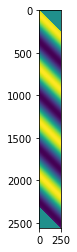

In [32]:
plt.imshow(numpy(M))

In [33]:
y = torch.pow(torch.mm(M,x), 2)
y = y / torch.norm(y)
y.shape

torch.Size([2560, 1])

In [34]:
# get the full eigendecomposition
J = po.synth.autodiff.jacobian(y, x) # full Jacobian
F = torch.mm(J.t(),J)

evals, evecs = torch.symeig(F, eigenvectors=True)


In [35]:
evals[-2] / evals[-1]


tensor(0.6296, grad_fn=<DivBackward0>)

In [36]:
lmbda_max, v_max = po.synth.eigendistortion.implicit_FIM_power_iteration(y, x, verbose=True)
lmbda_min, v_min = po.synth.eigendistortion.implicit_FIM_power_iteration(y, x, lmbda_max, verbose=True)


0 [1.3749361]
1 [1.2675037]
2 [0.8252926]
3 [0.41697788]
4 [0.18383408]
5 [0.07616234]
6 [0.03072357]
7 [0.0122776]
8 [0.00485802]
9 [0.00193977]
10 [0.00078201]
11 [0.00029755]
12 [0.00012207]
13 [4.5776367e-05]
14 [1.9073486e-05]
15 [1.9073486e-06]
16 [0.]
0 [2.1083622]
1 [1.1990671]
2 [4.044124]
3 [3.6032953]
4 [0.9226387]
5 [0.1451289]
6 [0.02141018]
7 [0.00374927]
8 [0.00125799]
9 [0.0008975]
10 [0.00083593]
11 [0.00081679]
12 [0.00080383]
13 [0.00079209]
14 [0.00078119]
15 [0.00077061]
16 [0.00076054]
17 [0.00075072]
18 [0.00074126]
19 [0.00073203]
20 [0.0007235]
21 [0.00071515]
22 [0.00070693]
23 [0.00069918]
24 [0.00069183]
25 [0.00068447]
26 [0.00067715]
27 [0.00067087]
28 [0.00066407]
29 [0.00065778]
30 [0.00065169]
31 [0.00064586]
32 [0.0006399]
33 [0.00063449]
34 [0.00062926]
35 [0.00062372]
36 [0.00061892]
37 [0.00061385]
38 [0.00060919]
39 [0.00060454]
40 [0.00060005]
41 [0.0005956]
42 [0.00059141]
43 [0.00058733]
44 [0.00058322]
45 [0.00057936]
46 [0.00057542]
47 [0.0005

In [37]:
evals[-1], lmbda_max 

(tensor(16.4059, grad_fn=<SelectBackward>),
 tensor([[16.4059]], grad_fn=<MmBackward>))

In [38]:
evals[0], lmbda_min

(tensor(-1.6758e-08, grad_fn=<SelectBackward>),
 tensor([[0.1083]], grad_fn=<MmBackward>))

In [39]:
# TODO explain why
# power method skips small noise evals
# and stops at the elbow of the spectrum

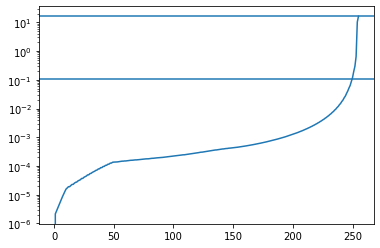

In [40]:
plt.semilogy(numpy(evals))
plt.axhline(numpy(lmbda_min))
plt.axhline(numpy(lmbda_max))

In [41]:
torch.norm(evecs[:,-1]), torch.norm(v_max)

(tensor(1.0000, grad_fn=<NormBackward0>),
 tensor(1.0000, grad_fn=<NormBackward0>))

In [42]:
torch.dot(evecs[:,-1], v_max.view(-1))

tensor(1.0000, grad_fn=<DotBackward>)

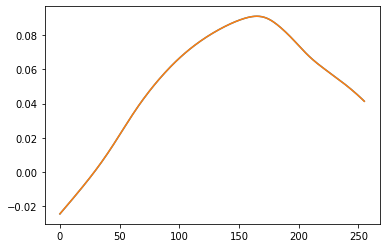

In [43]:
true = numpy(evecs[:,-1])
test = numpy(v_max).squeeze()

plt.plot(true)
plt.plot(test)

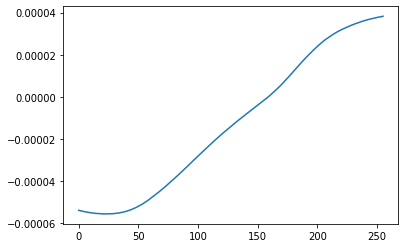

In [44]:
plt.plot(true-test);

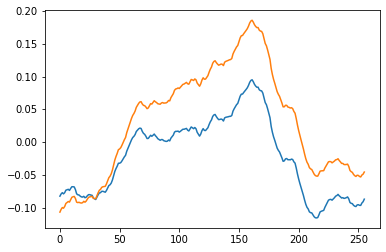

In [45]:
inpt = x.detach().numpy().squeeze()

plt.plot(inpt)
plt.plot(inpt + test)

In [46]:
# LEAST
# print(evecs[:,0].detach().dot(v_min.detach().squeeze()))
# print(torch.norm(evecs[:,0] - v_min))

# pt.imCompare(evecs[:,0].detach().numpy(), v_min.detach().numpy())

# plt.plot((evecs[:,0].detach() - v_min.detach().squeeze()).numpy())
# plt.show()

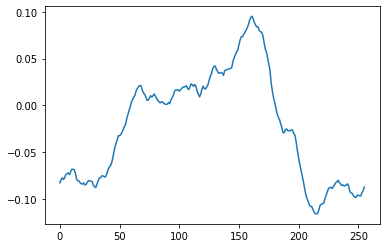

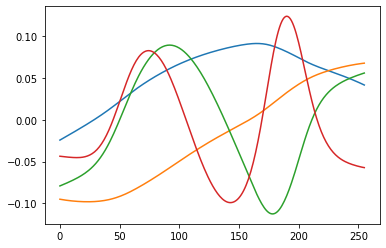

In [47]:
plt.plot(inpt)
plt.show()

# MOST
for i in range(1,5):
    plt.plot(numpy(evecs[:,-i]))
plt.show()

# LEAST
# for i in range(5):
#     plt.plot(evecs[:,i].detach().numpy())
# plt.show()

## *Example 2:* synthetic data,  Fourier transform, non-linearity

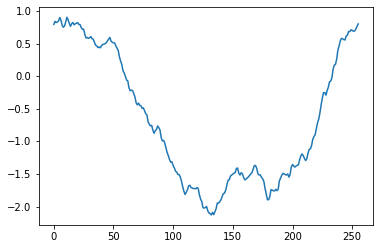

In [48]:
input_dim  = 2 ** 8
output_dim = 10 * input_dim

# x = torch.randint(0,255,(input_dim, 1), dtype=dtype, requires_grad=True)
img = pt.synthetic_images.pink_noise((input_dim, 1), fract_dim=1.2)
plt.plot(img)

x = torch.tensor(img, dtype=dtype, requires_grad=True)
x = x / torch.norm(x)

In [49]:
sp = torch.rfft(x,2)

# amplitude = torch.sqrt(torch.pow(sp.select(-1,0), 2) + torch.pow(sp.select(-1,1), 2))
# phase = torch.atan2(sp.select(-1,1),sp.select(-1,0))

amplitude, phase = po.rectangular_to_polar(sp.select(-1,0),sp.select(-1,1))

# several possibilities to explore
# y = phase
# y = amplitude
# y = torch.cat((amplitude, phase))
y = torch.cat((torch.log(torch.pow(amplitude, 2)), torch.pow(phase, 3)))

y = y / torch.norm(y)

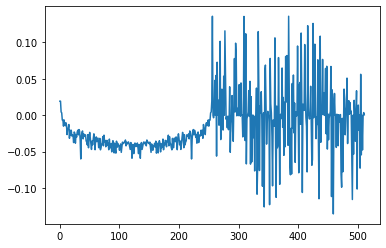

In [50]:
plt.plot(numpy(y)) #[np.roll(np.arange(input_dim), input_dim // 2)])

In [51]:
x.shape, y.shape

(torch.Size([256, 1]), torch.Size([512, 1]))

In [52]:
lmbda_max, v_max = po.synth.eigendistortion.implicit_FIM_power_iteration(y, x, verbose=True)
lmbda_min, v_min = po.synth.eigendistortion.implicit_FIM_power_iteration(y, x, lmbda_max, n_steps=1000, verbose=True)

0 [300030.2]
1 [104008.16]
2 [23675.375]
3 [5894.1875]
4 [1706.25]
5 [530.625]
6 [169.]
7 [54.0625]
8 [18.3125]
9 [5.]
10 [1.75]
11 [0.6875]
12 [0.125]
13 [0.25]
14 [0.0625]
15 [0.0625]
16 [0.1875]
17 [0.375]
18 [0.1875]
19 [0.375]
20 [0.4375]
21 [0.]
0 [108582.26]
1 [27092.523]
2 [17524.867]
3 [11369.848]
4 [7374.4883]
5 [4860.8047]
6 [3337.7344]
7 [2438.9922]
8 [1914.5078]
9 [1606.6172]
10 [1421.0352]
11 [1303.4062]
12 [1223.1172]
13 [1163.0137]
14 [1113.6328]
15 [1069.9121]
16 [1029.0293]
17 [989.58203]
18 [950.7539]
19 [912.3047]
20 [874.05273]
21 [836.0488]
22 [798.35547]
23 [761.1543]
24 [724.49414]
25 [688.5781]
26 [653.541]
27 [619.4492]
28 [586.49414]
29 [554.7324]
30 [524.2129]
31 [495.05664]
32 [467.25977]
33 [440.85547]
34 [415.86914]
35 [392.26172]
36 [370.0625]
37 [349.21777]
38 [329.6797]
39 [311.43848]
40 [294.4248]
41 [278.58105]
42 [263.86035]
43 [250.2207]
44 [237.57422]
45 [225.88086]
46 [215.07422]
47 [205.1084]
48 [195.91016]
49 [187.45605]
50 [179.65332]
51 [172.

In [53]:
J = numpy(po.synth.autodiff.jacobian(y, x))
print(J.shape)
F = J.T.dot(J)

evals, evecs = np.linalg.eigh(F)

(512, 256)


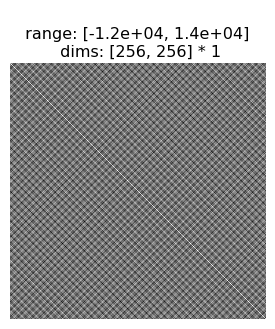

In [54]:
# little reasoning exercise
# pt.imshow(J.dot(J.T), vrange='auto3', title=None);

pt.imshow(F, vrange='auto1');

0.56777626

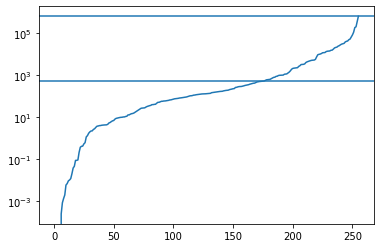

In [55]:
plt.semilogy(evals)
plt.axhline(numpy(lmbda_min))
plt.axhline(numpy(lmbda_max))
evals[-2] / evals[-1]


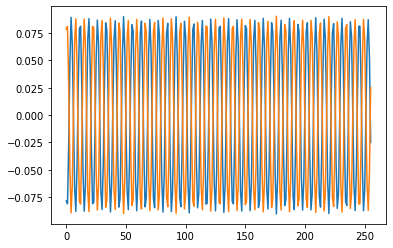

In [56]:
plt.plot(evecs[:,-1])
plt.plot(numpy(v_max).squeeze());

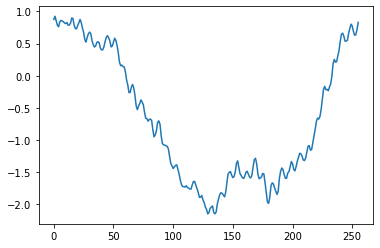

In [57]:
plt.plot(img.squeeze() + numpy(v_max).squeeze())

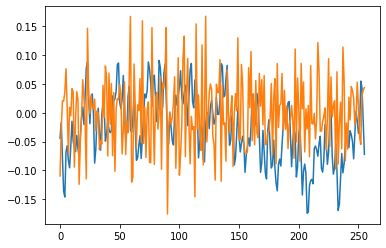

In [58]:
plt.plot(evecs[:,0])
# plt.plot(evecs[:,1])

plt.plot(numpy(v_min));

## *Example 3:* image data,  steerable pyramid, square, normalize

In [59]:
# TODO this example needs a little babysitting

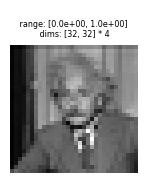

In [60]:
image = plt.imread('../data/einstein.pgm').astype(float)
image = pt.blurDn(image, 3, 'qmf9')
# keeping it small, so that we can rapidly check against the exact computation
image = po.rescale(image, 0, 1)
pt.imshow(image, zoom=4);


# TODO let the Eigendistortion class take care of that when it recieves a numpy array
x = torch.tensor(image).unsqueeze(0).unsqueeze(0)

In [61]:
class toy_model(nn.Module):
    def __init__(self):
        super(toy_model, self).__init__()

        self.SPF = po.simul.Steerable_Pyramid_Freq(image.shape, order=2, height=2)
        self.nl = po.simul.local_gain_control
    
    def forward(self, x):
        
        pyr = self.SPF(x) 
        _, state = self.nl(pyr)

        return torch.cat([s.squeeze().view(-1) for s in state.values()]).unsqueeze(1)

In [62]:
M = toy_model()

In [63]:
E = po.synth.Eigendistortion(x, M)

In [64]:
edist = E.synthesize(jac=False)

out size torch.Size([3840, 1]) in size torch.Size([1024, 1])
implicit power method, computing the maximum distortion
0 [5149.0293]
1 [3373.6328]
2 [1603.8467]
3 [809.40625]
4 [535.36914]
5 [456.73633]
6 [438.5]
7 [424.7129]
8 [393.96484]
9 [344.01367]
10 [282.77734]
11 [220.45508]
12 [164.70312]
13 [119.11719]
14 [84.11328]
15 [58.404297]
16 [40.08008]
17 [27.273438]
18 [18.449219]
19 [12.4453125]
20 [8.376953]
21 [5.6054688]
22 [3.7714844]
23 [2.5332031]
24 [1.6875]
25 [1.1367188]
26 [0.7421875]
27 [0.515625]
28 [0.34375]
29 [0.20507812]
30 [0.15429688]
31 [0.1015625]
32 [0.07421875]
33 [0.05078125]
34 [0.0234375]
35 [0.03125]
36 [0.]
implicit power method, computing the minimum distortion
0 [1989.1201]
1 [863.3003]
2 [578.7632]
3 [436.0078]
4 [344.9287]
5 [280.46924]
6 [231.78955]
7 [193.61829]
8 [163.09912]
9 [138.44629]
10 [118.42493]
11 [102.10474]
12 [88.743164]
13 [77.75952]
14 [68.690796]
15 [61.162964]
16 [54.87915]
17 [49.597412]
18 [45.125977]
19 [41.316406]
20 [38.04309]
21

[autoreload of plenoptic failed: Traceback (most recent call last):
  File "/Users/pe/anaconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/Users/pe/anaconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/Users/pe/anaconda3/envs/pytorch/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/pe/anaconda3/envs/pytorch/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/pe/Drive/_Code/2_SignalProcessing/plenoptic/plenoptic/__init__.py", line 8, in <module>
    from .tools.visualization import *

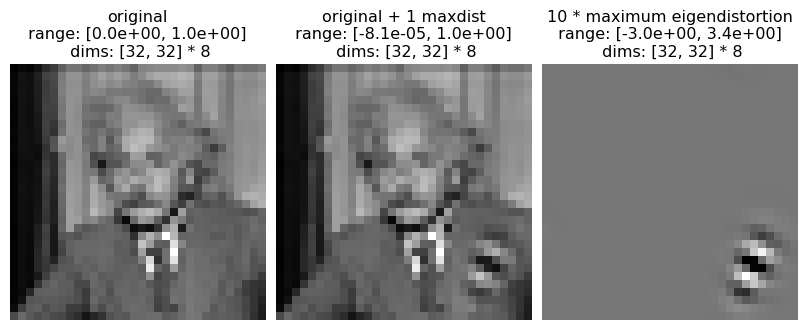

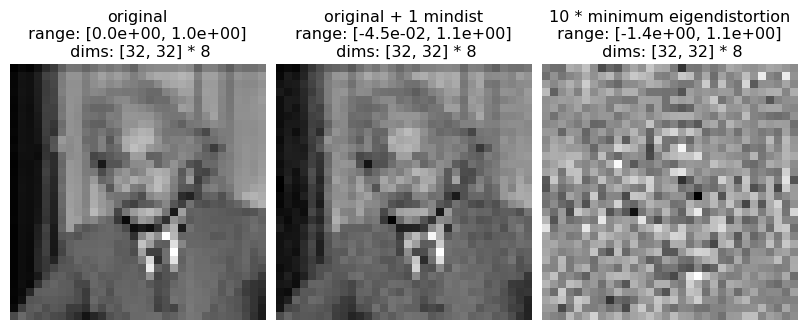

In [65]:
E.display(1, zoom = 8)

In [105]:
# TODO

# full_edist = E.synthesize(jac=True)
# E.display(1, zoom = 8)

# plt.semilogy([full_edist[str(i)][0] for i in range(1024)]);
# plt.axhline(numpy(edist['0'][0]))
# plt.axhline(numpy(edist['1023'][0]))

# Going beyond the first and last eigenvalues: Lanczos method

also compare to the block power methods

## *Example 4:* larger image